<a href="https://colab.research.google.com/github/rafaelbragae/AOC_trabalho/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predição de câncer e tratamento de fairness do modelo**

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

##**Bibliotecas**

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import cv2
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import os
from distutils.dir_util import copy_tree, remove_tree

from tensorflow.keras.applications import DenseNet121,InceptionV3,Xception
from tensorflow.keras.applications import InceptionResNetV2
from keras.applications import ResNet152V2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score,mean_squared_error

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from skimage.transform import resize

from skimage import io
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

import plotly.graph_objects as gp

import os
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Visualização das imagens do conjunto
def visualize(direction):
    list_dir=os.listdir(direction)
    plt.figure(figsize=(14,8))
    for i in range(1,7):
        plt.subplot(2,3,i)
        img= plt.imread(os.path.join(direction,list_dir[i]))
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.tight_layout()

In [ ]:
# Aumento dos dados
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

##**Conjunto de dados HAM10000**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [00:54<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


###***Manipulação do conjunto***

In [ ]:
ham10000_dir = '/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2'
ham10000_csv_path = '/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_metadata.csv'

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(ham10000_dir, '*', '*.jpg'))}

# Read the CSV file into a Pandas DataFrame
df_ham10000 = pd.read_csv(ham10000_csv_path)

# Now you can access columns and use the map function
df_ham10000['path_jpeg'] = df_ham10000['image_id'].map(imageid_path_dict.get)

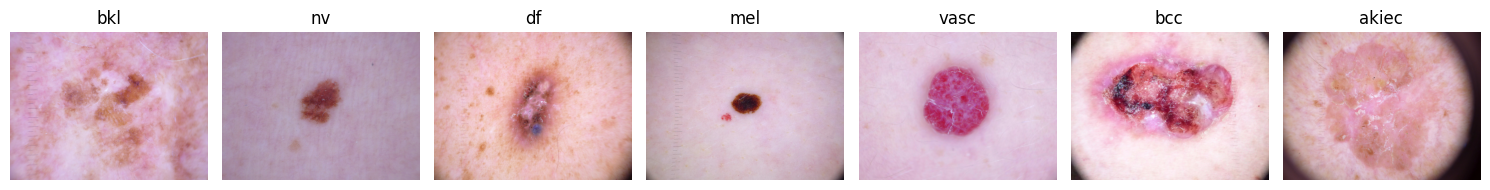

In [ ]:
# Garantindo que os caminhos das imagens existem e estão corretos
for i in range(len(df_ham10000)):
    if not os.path.isfile(df_ham10000['path_jpeg'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {df_ham10000['path_jpeg'].iloc[i]}")

# Uma imagem por classe
class_images = df_ham10000.drop_duplicates(subset='dx')

# Printando uma imagem por classe
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['path_jpeg'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['dx'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

plot_class_images(class_images)

In [ ]:
df_ham10000.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path_jpeg,0


In [ ]:
# Removendo instâncias que tem os dados sensíveis faltantes
df_ham10000.dropna(inplace=True)

# Removendo instâncias em que o sexo é indefinido
df_ham10000 = df_ham10000[df_ham10000['sex']  != "unknown"]

# Função de undersampling para reduzir a classe majoritária
classe_majoritaria = df_ham10000[df_ham10000['dx'] == 'nv']
classe_minoritarias = df_ham10000[df_ham10000['dx'] != 'nv']

n_amostras = int(len(classe_minoritarias)/2)

classe_majoritaria_reduzida = classe_majoritaria.sample(n=n_amostras, random_state=42)

df_ham_balanceado = pd.concat([classe_majoritaria_reduzida, classe_minoritarias])

df_ham_balanceado = df_ham_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Resultado após o balanceamento
count_ham_balanceado = df_ham_balanceado['dx'].value_counts().reset_index()
normalize_ham_balanceado = df_ham_balanceado['dx'].value_counts(normalize=True).reset_index()
pd.merge(count_ham_balanceado, normalize_ham_balanceado, on="dx")

,dx,count,proportion
0,nv,1649,0.333333
1,mel,1111,0.224581
2,bkl,1089,0.220133
3,bcc,514,0.103901
4,akiec,327,0.066101
5,vasc,142,0.028704
6,df,115,0.023246


In [ ]:
df_ham_balanceado['sex'].value_counts(normalize=True)

,proportion
sex,
male,0.572064
female,0.427936


In [ ]:
df_ham_balanceado['age'].value_counts(normalize=True)

,proportion
age,
70.0,0.116030
45.0,0.104508
55.0,0.102486
50.0,0.096018
60.0,0.093996
65.0,0.093390
75.0,0.088943
40.0,0.067920
80.0,0.066505


In [ ]:
# Quantidade de pacientes em cada faixa de idade por sexo
result_ham = df_ham_balanceado.groupby(['age', 'sex']).size().unstack(fill_value=0)

print(result_ham)

sex   female  male
age               
0.0       10     7
5.0        8    19
10.0       5     6
15.0      12     9
20.0      24    27
25.0      49    29
30.0      93    50
35.0     139    92
40.0     178   158
45.0     251   266
50.0     218   257
55.0     212   295
60.0     214   251
65.0     183   279
70.0     206   368
75.0     138   302
80.0      89   240
85.0      88   175


In [ ]:
final_results_ham = result_ham.reset_index()

In [ ]:
ages = ['0.0', '5.0', '10.0', '15.0', '20.0', '25.0', '30.0', '35.0', '40.0', '45.0', '50.0', '55.0', '60.0', '65.0', '70.0', '75.0', '80.0', '85.0']

In [ ]:
y_age_h = final_results_ham['age']
x_M_h = final_results_ham['male']*-1
x_F_h = final_results_ham['female']

In [ ]:
#  Creating instance of the figure
fig = gp.Figure()

# Adding Male data to the figure
fig.add_trace(gp.Bar(y= y_age_h, x = x_M_h,
					name = 'Homem',
					orientation = 'h'))

# Adding Female data to the figure
fig.add_trace(gp.Bar(y = y_age_h, x = x_F_h,
					name = 'Mulher', orientation = 'h'))

# Updating the layout for our graph
fig.update_layout(title = 'Pirâmide Etária',
				title_font_size = 22, barmode = 'relative',
				bargap = 0.0, bargroupgap = 0,
				xaxis = dict(tickvals = [-1500, -1000, -500,
										0, 500, 1000, 1500],

							ticktext = ['1500', '1000', '500', '0',
										'500', '1000', '1500'],

							title = 'População',
							title_font_size = 14)
				)

fig.show()

In [ ]:
df_ham_balanceado['benign_malignant'] = np.where(
     df_ham_balanceado['dx'] == 'mel',
    'malignant',
     'benign'
)

df_ham_balanceado['target'] = np.where(
     df_ham_balanceado['dx'] == 'mel',
     1,
     0
)

df_ham_balanceado['faixa_idade'] = np.where(
     (df_ham_balanceado['age'] >= 0) & (df_ham_balanceado['age'] <= 14),
     "Criança/Pré Adolescente",
     np.where(
        (df_ham_balanceado['age'] >= 15) & (df_ham_balanceado['age'] <= 30), "Jovem Adulto",
        np.where(
            (df_ham_balanceado['age'] >= 31) & (df_ham_balanceado['age'] <= 60), "Adulto", "Idoso"
        )
     )
)

# Drop das colunas que não são úteis
df_ham_balanceado.drop(['lesion_id'], axis=1, inplace=True)

df_ham_balanceado.head()

,image_id,dx,dx_type,age,sex,localization,path_jpeg,benign_malignant,target,faixa_idade
0,ISIC_0032002,nv,follow_up,45.0,male,back,/root/.cache/kagglehub/datasets/kmader/skin-ca...,benign,0,Adulto
1,ISIC_0028263,nv,histo,75.0,female,lower extremity,/root/.cache/kagglehub/datasets/kmader/skin-ca...,benign,0,Idoso
2,ISIC_0026619,nv,follow_up,50.0,male,abdomen,/root/.cache/kagglehub/datasets/kmader/skin-ca...,benign,0,Adulto
3,ISIC_0029889,vasc,histo,40.0,female,chest,/root/.cache/kagglehub/datasets/kmader/skin-ca...,benign,0,Adulto
4,ISIC_0033031,vasc,histo,45.0,male,upper extremity,/root/.cache/kagglehub/datasets/kmader/skin-ca...,benign,0,Adulto


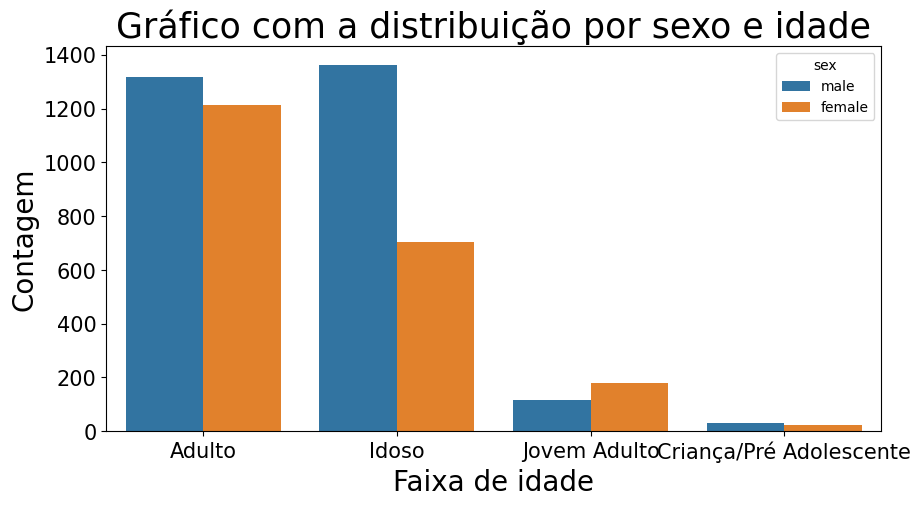

In [ ]:
#Gráfico com a distribuição por sexo e diagnóstico
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df_ham_balanceado, x='faixa_idade', hue='sex')
ax.set_xlabel(xlabel = 'Faixa de idade', fontsize = 20)
ax.set_ylabel(ylabel = 'Contagem', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Gráfico com a distribuição por sexo e idade", fontsize = 25)
plt.show()

In [ ]:
# df_ham_balanceado.to_csv('ham.csv', index=False)

In [ ]:
df_ham_balanceado['benign_malignant'].value_counts(normalize=True).reset_index()

,benign_malignant,proportion
0,benign,0.775419
1,malignant,0.224581


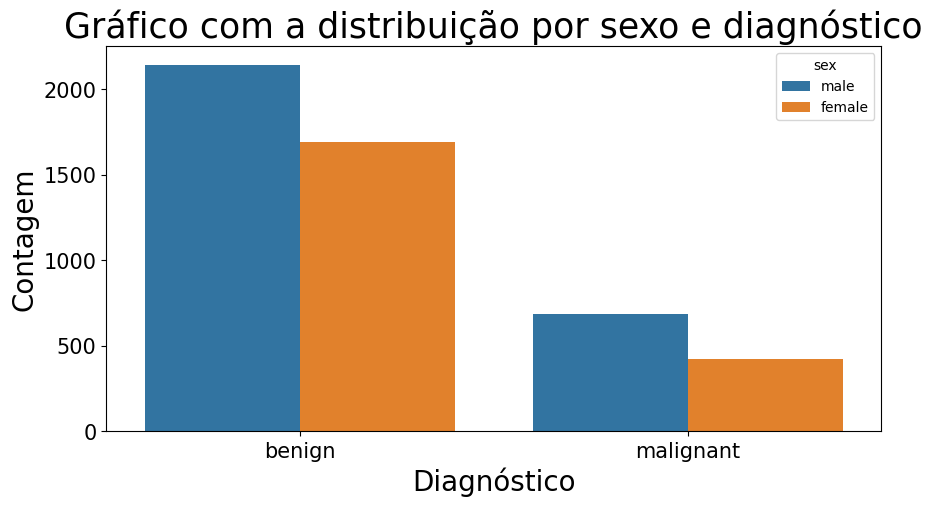

In [ ]:
#Gráfico com a distribuição por sexo e diagnóstico
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df_ham_balanceado, x='benign_malignant', hue='sex')
ax.set_xlabel(xlabel = 'Diagnóstico', fontsize = 20)
ax.set_ylabel(ylabel = 'Contagem', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Gráfico com a distribuição por sexo e diagnóstico", fontsize = 25)
plt.show()

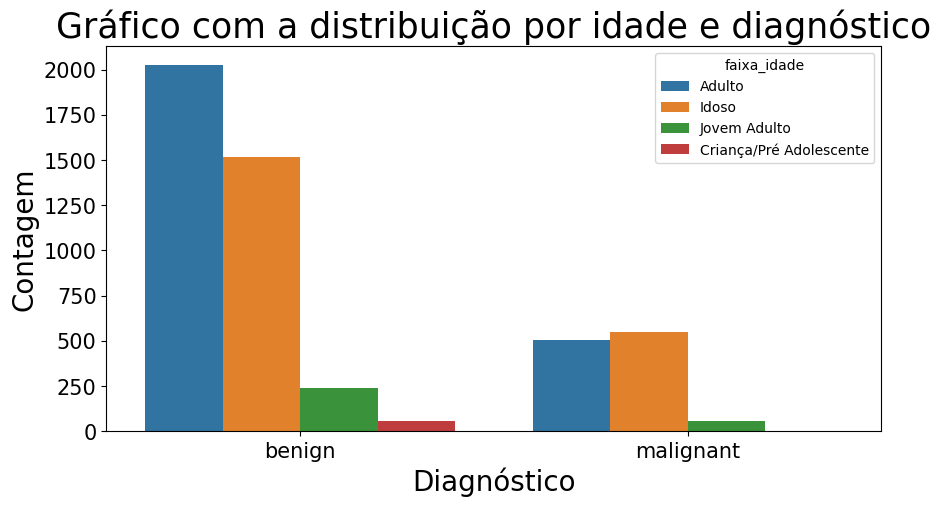

In [ ]:
#Gráfico com a distribuição por idade e diagnóstico
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df_ham_balanceado, x='benign_malignant', hue='faixa_idade')
ax.set_xlabel(xlabel = 'Diagnóstico', fontsize = 20)
ax.set_ylabel(ylabel = 'Contagem', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Gráfico com a distribuição por idade e diagnóstico", fontsize = 25)
plt.show()

In [ ]:
# Juntando o diagnóstico de doenças que são relacionadas
df_ham_balanceado['modified_diagnosis'] = np.where(
     (df_ham_balanceado['dx'] == "bcc") | (df_ham_balanceado['dx'] == "akiec"),
     "BCC/AK",
     np.where(
        (df_ham_balanceado['dx'] == "bkl") | (df_ham_balanceado['dx'] == "df"), "BKL/DF", df_ham_balanceado['dx']
     )
)

In [ ]:
df_ham_balanceado['modified_diagnosis'].value_counts(normalize=True)

,proportion
modified_diagnosis,
nv,0.333333
BKL/DF,0.243380
mel,0.224581
BCC/AK,0.170002
vasc,0.028704


In [ ]:
diagnosis_mapping = {
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-Like Lesions',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic Nevi'
}

# Create a new column with the updated diagnosis names
df_ham_balanceado['Updated_Diagnosis'] = df_ham_balanceado['dx'].map(diagnosis_mapping)

###***Modelo CNN***

In [ ]:
# Separate features (X) and target variable (y)
X_ham = df_ham_balanceado.drop(columns=['Updated_Diagnosis'])
y_ham = df_ham_balanceado['Updated_Diagnosis']

# Display the shape of X and y
print("Shape of features (X):", X_ham.shape)
print("Shape of target variable (y):", y_ham.shape)

Shape of features (X): (4947, 11)
Shape of target variable (y): (4947,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ham, y_ham, test_size=0.2, random_state=42)

In [ ]:
y_test.value_counts()

,count
Updated_Diagnosis,
Melanocytic Nevi,336
Melanoma,222
Benign Keratosis-Like Lesions,203
Basal Cell Carcinoma,118
Actinic Keratoses,66
Vascular Lesions,25
Dermatofibroma,20


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col='path_jpeg',
    y_col='dx',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='path_jpeg',
    y_col='dx',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 3957 validated image filenames belonging to 7 classes.
Found 990 validated image filenames belonging to 7 classes.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
            metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='model_weights.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
with tf.device('/device:GPU:0'):
  history=model.fit(
      train_generator,
      epochs=10,
      batch_size=100,
      validation_data=test_generator,
      callbacks=[reduce_lr, early_stopping]
  )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



62/62 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.3869 - loss: 4.9075 - val_accuracy: 0.4606 - val_loss: 2.4203 - learning_rate: 0.0010
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.4688 - loss: 2.2030 - val_accuracy: 0.4768 - val_loss: 1.7757 - learning_rate: 0.0010
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.4845 - loss: 1.7487 - val_accuracy: 0.4505 - val_loss: 1.6046 - learning_rate: 0.0010
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.4939 - loss: 1.5661 - val_accuracy: 0.4778 - val_loss: 1.4782 - learning_rate: 0.0010
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5155 - loss: 1.4774 - val_accuracy: 0.5061 - val_loss: 1.4459 - learning_rate: 0.0010
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5137 - loss: 1.4479 - val_accuracy: 0.5162 - val_loss: 1.3659 - learning_rate: 0.0010
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5250 - loss: 1.3963 - val_accuracy: 0.4848 -

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - accuracy: 0.4973 - loss: 1.3493
Test Accuracy: 0.51


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(train_generator)
print(f"Train Accuracy: {accuracy:.2f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5824 - loss: 1.2497
Train Accuracy: 0.57


In [ ]:
# Predictions
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Metrics
true_classes = test_generator.classes
accuracy = accuracy_score(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])
report = classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys()), output_dict=True)
precision = report['macro avg']['precision']
f1_score = report['macro avg']['f1-score']
auc = roc_auc_score(tf.keras.utils.to_categorical(true_classes), predictions, multi_class='ovr')
mse = mean_squared_error(true_classes, predicted_classes)
bias = (np.mean(predicted_classes) - np.mean(true_classes)) ** 2
variance = np.var(predicted_classes)


print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-Score: {f1_score:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Variance: {variance:.2f}")
print(f"Bias: {bias:.2f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 614ms/step
Accuracy: 0.51
Sensitivity: 1.00
Specificity: 0.25
Precision: 0.46
F1-Score: 0.32
AUC: 0.85
Mean Squared Error: 2.91
Variance: 1.90
Bias: 0.33


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step


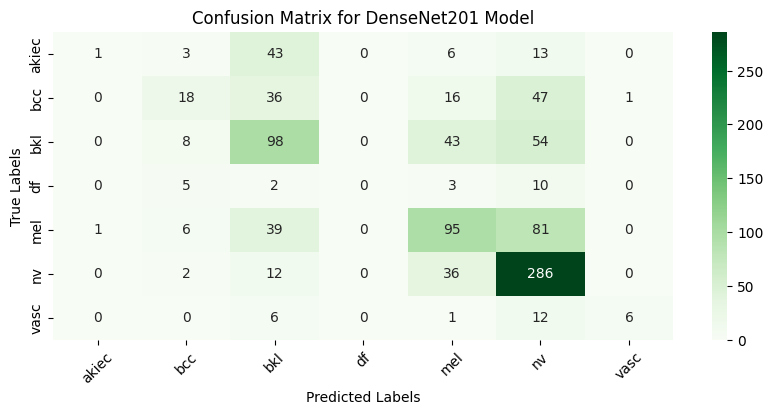

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão para o modelo DenseNet201')
plt.xticks(rotation=45)
plt.show()

###***Segundo Modelo CNN***

In [ ]:
train_generator2 = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col='path_jpeg',
    y_col='modified_diagnosis',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator2 = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='path_jpeg',
    y_col='modified_diagnosis',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 3957 validated image filenames belonging to 5 classes.
Found 990 validated image filenames belonging to 5 classes.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions2 = Dense(5, activation='softmax')(x)

In [ ]:
model2 = Model(inputs=base_model.input, outputs=predictions2)

model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
            metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history=model2.fit(
      train_generator2,
      epochs=10,
      batch_size=100,
      validation_data=test_generator2,
      callbacks=[reduce_lr, early_stopping]
  )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



62/62 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.4086 - loss: 4.6386 - val_accuracy: 0.5091 - val_loss: 2.1940 - learning_rate: 0.0010
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5225 - loss: 1.9788 - val_accuracy: 0.4960 - val_loss: 1.6292 - learning_rate: 0.0010
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5204 - loss: 1.5409 - val_accuracy: 0.5081 - val_loss: 1.4269 - learning_rate: 0.0010


In [ ]:
loss, accuracy = model2.evaluate(test_generator2)
print(f"Test Accuracy: {accuracy:.2f}")

loss, accuracy = model2.evaluate(train_generator2)
print(f"Train Accuracy: {accuracy:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 468ms/step - accuracy: 0.5004 - loss: 2.2129
Test Accuracy: 0.51
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 459ms/step - accuracy: 0.5004 - loss: 2.2129
Train Accuracy: 0.51


In [ ]:
# Predictions
predictions = model2.predict(test_generator2, steps=len(test_generator2), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Metrics
true_classes = test_generator2.classes
accuracy = accuracy_score(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])
report = classification_report(true_classes, predicted_classes, target_names=list(test_generator2.class_indices.keys()), output_dict=True)
precision = report['macro avg']['precision']
f1_score = report['macro avg']['f1-score']
auc = roc_auc_score(tf.keras.utils.to_categorical(true_classes), predictions, multi_class='ovr')
mse = mean_squared_error(true_classes, predicted_classes)
bias = (np.mean(predicted_classes) - np.mean(true_classes)) ** 2
variance = np.var(predicted_classes)


print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-Score: {f1_score:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Variance: {variance:.2f}")
print(f"Bias: {bias:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 513ms/step
Accuracy: 0.51
Sensitivity: 0.93
Specificity: 0.32
Precision: 0.62
F1-Score: 0.40
AUC: 0.81
Mean Squared Error: 1.41
Variance: 0.89
Bias: 0.10


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step


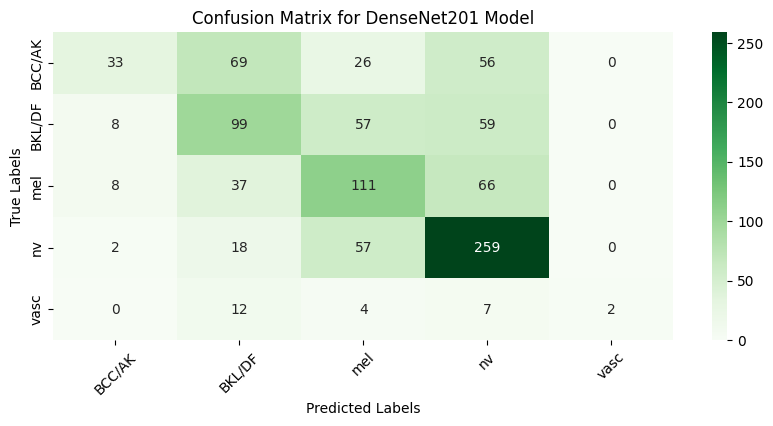

In [ ]:
predictions = model2.predict(test_generator2)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator2.classes

class_labels = list(test_generator2.class_indices.keys())
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão para o modelo DenseNet201')
plt.xticks(rotation=45)
plt.show()

In [ ]:
aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip with probability 0.5
    iaa.Affine(rotate=(-10, 10)),  # Random rotation within -10 to 10 degrees
    iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),  # Random scaling within 90% to 110%
    iaa.Crop(percent=(0, 0.2)),# Crop images from each side by 0% to 20% of their height/width
    iaa.Affine(shear=(-5, 5)),  # Random shear within -5 to 5 degrees
    iaa.GaussianBlur(sigma=(0, 0.5)),  # Gaussian blur with a small sigma
    iaa.AdditiveGaussianNoise(scale=(0, 0.01*255)),  # Small additive Gaussian noise
    iaa.ContrastNormalization((0.9, 1.1)),  # Slightly change contrast
    iaa.CLAHE(clip_limit=(1, 2))  # Apply CLAHE with a moderate clip limit
])

augmented_images_dir = '/path/to/augmented_images'
os.makedirs(augmented_images_dir, exist_ok=True)

class_counts = df_ham_balanceado['dx'].value_counts()
max_count = class_counts.max()
balanced_samples = []

for label in class_counts.index:
    class_subset = df_ham_balanceado[df_ham_balanceado['dx'] == label]

    if len(class_subset) < max_count:
        n_augmentations = max_count - len(class_subset)
        augmented_samples = []
        for i in range(n_augmentations):
            sample = class_subset.sample(n=1, random_state=42).iloc[0]
            img_path = sample['path_jpeg']
            img = io.imread(img_path)
            augmented_image = aug_pipeline(image=img)

            augmented_image_path = os.path.join(augmented_images_dir, f'{label}_augmented_{i}.jpg')
            io.imsave(augmented_image_path, augmented_image)

            augmented_sample = sample.copy()
            augmented_sample['path_jpeg'] = augmented_image_path
            augmented_samples.append(augmented_sample)

        augmented_df = pd.DataFrame(augmented_samples)
        class_oversampled = pd.concat([class_subset, augmented_df], ignore_index=True)
    else:
        class_oversampled = class_subset

    balanced_samples.append(class_oversampled)

balanced_dataset = pd.concat(balanced_samples).reset_index(drop=True)

print("Dataset balanced successfully!")

meta_data = balanced_dataset

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning:

Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.



Dataset balanced successfully!


In [ ]:
X_new = meta_data.drop(columns=['Updated_Diagnosis'])
y_new = meta_data['Updated_Diagnosis']

print("Shape of features (X):", X_new.shape)
print("Shape of target variable (y):", y_new.shape)

Shape of features (X): (11543, 11)
Shape of target variable (y): (11543,)


In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [ ]:
train_generator3 = train_datagen.flow_from_dataframe(
    dataframe=X_train_new,
    x_col='path_jpeg',
    y_col='modified_diagnosis',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator3 = test_datagen.flow_from_dataframe(
    dataframe=X_test_new,
    x_col='path_jpeg',
    y_col='modified_diagnosis',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 9234 validated image filenames belonging to 5 classes.
Found 2309 validated image filenames belonging to 5 classes.


In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions3 = Dense(5, activation='softmax')(x)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model3 = Model(inputs=base_model.input, outputs=predictions3)

model3.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
            metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history=model3.fit(
      train_generator3,
      epochs=10,
      batch_size=100,
      validation_data=test_generator3,
      callbacks=[reduce_lr, early_stopping]
  )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



145/145 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.6156 - loss: 0.9752 - val_accuracy: 0.7731 - val_loss: 0.5784 - learning_rate: 0.0010
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.7653 - loss: 0.5826 - val_accuracy: 0.7956 - val_loss: 0.5058 - learning_rate: 0.0010
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.7810 - loss: 0.5378 - val_accuracy: 0.7969 - val_loss: 0.4966 - learning_rate: 0.0010
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.7751 - loss: 0.5436 - val_accuracy: 0.7943 - val_loss: 0.4786 - learning_rate: 0.0010
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.7996 - loss: 0.4933 - val_accuracy: 0.8194 - val_loss: 0.4439 - learning_rate: 0.0010
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.7967 - loss: 0.4950 - val_accuracy: 0.8099 - val_loss: 0.4552 - learning_rate: 0.0010
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8017 - loss: 0.4834 - val_

In [ ]:
loss, accuracy = model3.evaluate(test_generator3)
print(f"Test Accuracy: {accuracy:.2f}")

loss, accuracy = model3.evaluate(train_generator3)
print(f"Train Accuracy: {accuracy:.2f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 383ms/step - accuracy: 0.8269 - loss: 0.4351
Test Accuracy: 0.83
145/145 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.8265 - loss: 0.4143
Train Accuracy: 0.83


In [ ]:
# Predictions
predictions = model3.predict(test_generator3, steps=len(test_generator3), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Metrics
true_classes = test_generator3.classes
accuracy = accuracy_score(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])
report = classification_report(true_classes, predicted_classes, target_names=list(test_generator3.class_indices.keys()), output_dict=True)
precision = report['macro avg']['precision']
f1_score = report['macro avg']['f1-score']
auc = roc_auc_score(tf.keras.utils.to_categorical(true_classes), predictions, multi_class='ovr')
mse = mean_squared_error(true_classes, predicted_classes)
bias = (np.mean(predicted_classes) - np.mean(true_classes)) ** 2
variance = np.var(predicted_classes)


print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-Score: {f1_score:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Variance: {variance:.2f}")
print(f"Bias: {bias:.2f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 574ms/step
Accuracy: 0.83
Sensitivity: 0.93
Specificity: 0.93
Precision: 0.82
F1-Score: 0.82
AUC: 0.97
Mean Squared Error: 0.39
Variance: 1.98
Bias: 0.00


37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step


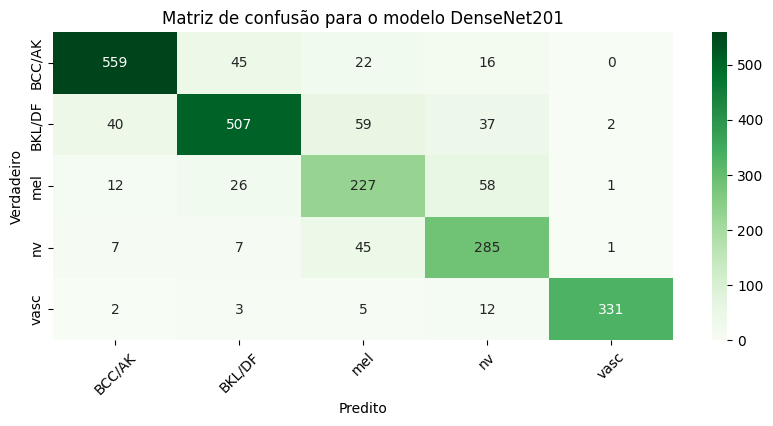

In [ ]:
predictions = model3.predict(test_generator3)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator3.classes

class_labels = list(test_generator3.class_indices.keys())
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão para o modelo DenseNet201')
plt.xticks(rotation=45)
plt.show()

##**Conjunto de dados ISIC 2019**

###***Manipulação do conjunto***

In [ ]:
isic_dir = '/content/drive/MyDrive/dados_tcc/isic2019/train'
# visualize(isic_dir)

In [ ]:
isic_csv = '/content/drive/MyDrive/dados_tcc/isic2019/train.csv'

In [ ]:
df_isic = pd.read_csv(isic_csv)
df_isic.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767


In [ ]:
# Drop das colunas que não são úteis
df_isic.drop(['patient_id', 'tfrecord', 'width', 'height'], axis=1, inplace=True)

# Coluna com o caminho para a imagem referente
df_isic['path_jpeg'] = isic_dir + '/' + df_isic['image_name'] + '.jpg'
print(df_isic['image_name'][0])
print(df_isic['path_jpeg'][0])

ISIC_0000000
/content/drive/MyDrive/dados_tcc/isic2019/train/ISIC_0000000.jpg


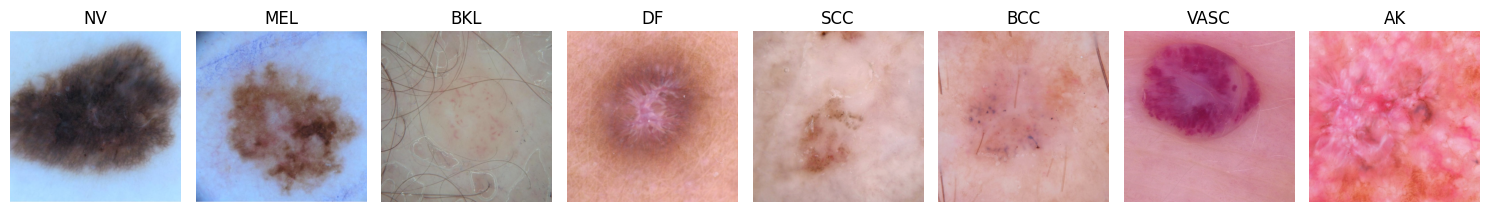

In [ ]:
# Garantindo que os caminhos das imagens existem e estão corretos
for i in range(len(df_isic)):
    if not os.path.isfile(df_isic['path_jpeg'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {df_isic['path_jpeg'].iloc[i]}")

# Uma imagem por classe
class_images = df_isic.drop_duplicates(subset='diagnosis')

# Printando uma imagem por classe
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['path_jpeg'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

plot_class_images(class_images)

In [ ]:
df_isic.isna().sum()

,0
image_name,0
sex,0
age_approx,437
anatom_site_general_challenge,2631
diagnosis,0
benign_malignant,0
target,0
path_jpeg,0


In [ ]:
df_isic['sex'].value_counts(normalize=True)

,proportion
sex,
male,0.524496
female,0.460345
unknown,0.015159


In [ ]:
# Removendo instâncias que tem os dados sensíveis faltantes
df_isic = df_isic[df_isic['age_approx'].notna()]

# Removendo instâncias em que o sexo é "unknown"
df_isic = df_isic[df_isic['sex']  != "unknown"]

# Função de undersampling para reduzir a classe majoritária
classe_majoritaria_isic = df_isic[df_isic['diagnosis'] == 'NV']
classe_minoritarias_isic = df_isic[df_isic['diagnosis'] != 'NV']

n_amostras = int(len(classe_minoritarias_isic)/2)

classe_majoritaria_reduzida_isic = classe_majoritaria_isic.sample(n=n_amostras, random_state=42)

df_isic_balanceado = pd.concat([classe_majoritaria_reduzida_isic, classe_minoritarias_isic])

df_isic_balanceado = df_isic_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Resultado após o balanceamento
count_isic_balanceado = df_isic_balanceado['diagnosis'].value_counts().reset_index()
normalize_isic_balanceado = df_isic_balanceado['diagnosis'].value_counts(normalize=True).reset_index()
pd.merge(count_isic_balanceado, normalize_isic_balanceado, on="diagnosis")

,diagnosis,count,proportion
0,NV,6168,0.333333
1,MEL,4437,0.239786
2,BCC,3317,0.179259
3,BKL,2598,0.140402
4,AK,864,0.046693
5,SCC,628,0.033939
6,VASC,253,0.013673
7,DF,239,0.012916


In [ ]:
df_isic_balanceado['age_approx'].value_counts(normalize=True)

,proportion
age_approx,
70.0,0.102843
50.0,0.092629
65.0,0.092142
45.0,0.088521
55.0,0.087549
60.0,0.087549
75.0,0.086738
40.0,0.076794
80.0,0.073281


In [ ]:
# Quantidade de pacientes em cada faixa de idade por sexo
result_isic = df_isic_balanceado.groupby(['age_approx', 'sex']).size().unstack(fill_value=0)

print(result_isic)

sex         female  male
age_approx              
0.0             15    14
5.0             19    35
10.0            49    32
15.0            89   105
20.0           114   100
25.0           230   131
30.0           436   302
35.0           573   413
40.0           751   670
45.0           839   799
50.0           884   830
55.0           785   835
60.0           754   866
65.0           691  1014
70.0           663  1240
75.0           560  1045
80.0           452   904
85.0           516   749


In [ ]:
final_results_isic = result_isic.reset_index()

In [ ]:
y_age_isic = final_results_isic['age_approx']
x_M_isic = final_results_isic['male']*-1
x_F_isic = final_results_isic['female']

In [ ]:
#  Creating instance of the figure
fig = gp.Figure()

# Adding Male data to the figure
fig.add_trace(gp.Bar(y= y_age_isic, x = x_M_isic,
					name = 'Homem',
					orientation = 'h'))

# Adding Female data to the figure
fig.add_trace(gp.Bar(y = y_age_isic, x = x_F_isic,
					name = 'Mulher', orientation = 'h'))

# Updating the layout for our graph
fig.update_layout(title = 'Pirâmide Etária',
				title_font_size = 22, barmode = 'relative',
				bargap = 0.0, bargroupgap = 0,
				xaxis = dict(tickvals = [-1500, -1000, -500,
										0, 500, 1000, 1500],

							ticktext = ['1500', '1000', '500', '0',
										'500', '1000', '1500'],

							title = 'População',
							title_font_size = 14)
				)

fig.show()


In [ ]:
df_isic_balanceado['faixa_idade'] = np.where(
     (df_isic_balanceado['age_approx'] >= 0) & (df_isic_balanceado['age_approx'] <= 14),
     "Criança/Pré Adolescente",
     np.where(
        (df_isic_balanceado['age_approx'] >= 15) & (df_isic_balanceado['age_approx'] <= 30), "Jovem Adulto",
        np.where(
            (df_isic_balanceado['age_approx'] >= 31) & (df_isic_balanceado['age_approx'] <= 60), "Adulto", "Idoso"
        )
     )
)

df_isic_balanceado.head()

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,path_jpeg,faixa_idade
0,ISIC_0028586,female,30.0,posterior torso,NV,benign,0,/content/drive/MyDrive/dados_tcc/isic2019/trai...,Jovem Adulto
1,ISIC_0059770,female,75.0,lower extremity,MEL,malignant,1,/content/drive/MyDrive/dados_tcc/isic2019/trai...,Idoso
2,ISIC_0054941,male,70.0,anterior torso,MEL,malignant,1,/content/drive/MyDrive/dados_tcc/isic2019/trai...,Idoso
3,ISIC_0010032,male,70.0,anterior torso,NV,benign,0,/content/drive/MyDrive/dados_tcc/isic2019/trai...,Idoso
4,ISIC_0026456,male,60.0,upper extremity,VASC,benign,0,/content/drive/MyDrive/dados_tcc/isic2019/trai...,Adulto


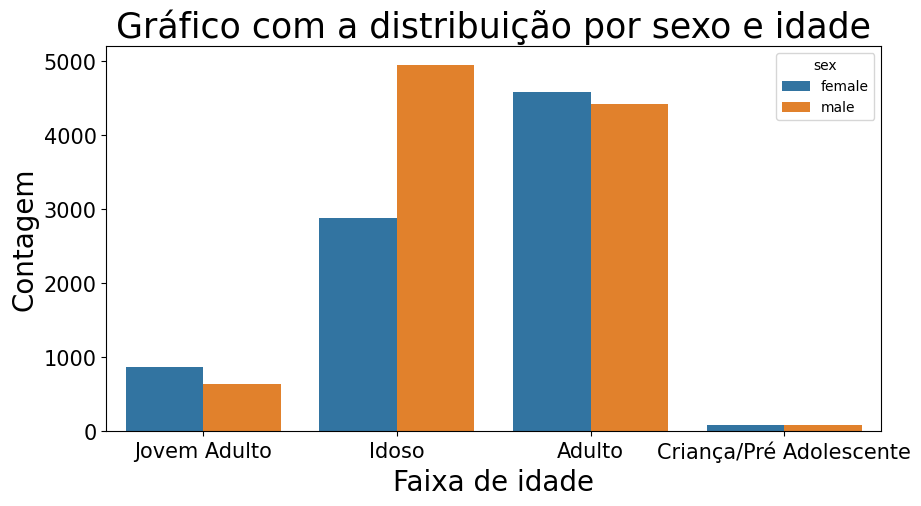

In [ ]:
#Gráfico com a distribuição por sexo e diagnóstico
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df_isic_balanceado, x='faixa_idade', hue='sex')
ax.set_xlabel(xlabel = 'Faixa de idade', fontsize = 20)
ax.set_ylabel(ylabel = 'Contagem', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Gráfico com a distribuição por sexo e idade", fontsize = 25)
plt.show()

In [ ]:
df_isic_balanceado['benign_malignant'].value_counts(normalize=True).reset_index()

,benign_malignant,proportion
0,benign,0.760214
1,malignant,0.239786


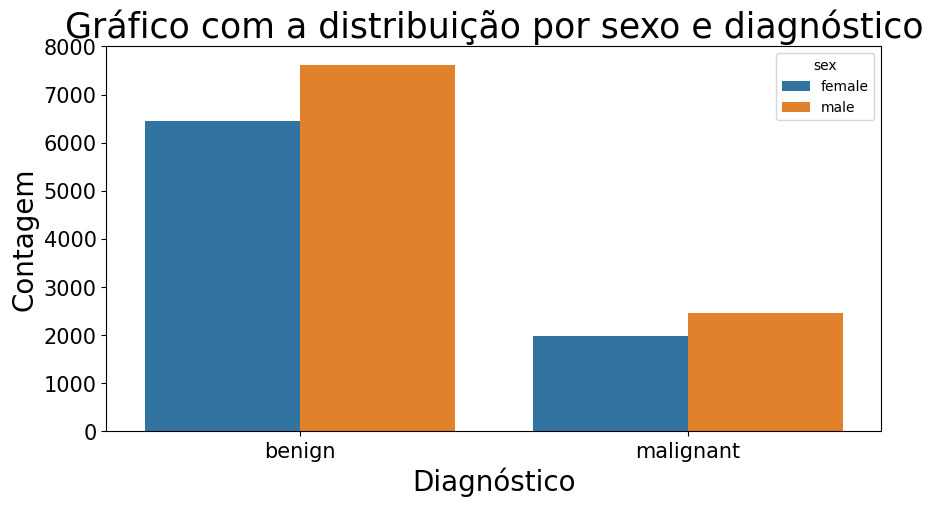

In [ ]:
#Gráfico com a distribuição por sexo e diagnóstico
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df_isic_balanceado, x='benign_malignant', hue='sex')
ax.set_xlabel(xlabel = 'Diagnóstico', fontsize = 20)
ax.set_ylabel(ylabel = 'Contagem', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Gráfico com a distribuição por sexo e diagnóstico", fontsize = 25)
plt.show()

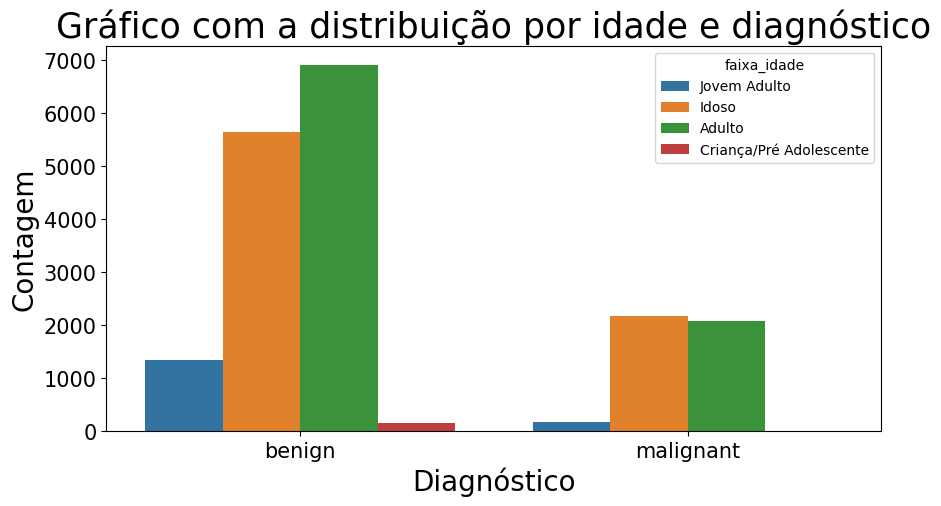

In [ ]:
#Gráfico com a distribuição por idade e diagnóstico
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df_isic_balanceado, x='benign_malignant', hue='faixa_idade')
ax.set_xlabel(xlabel = 'Diagnóstico', fontsize = 20)
ax.set_ylabel(ylabel = 'Contagem', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Gráfico com a distribuição por idade e diagnóstico", fontsize = 25)
plt.show()

In [ ]:
# Juntando o diagnóstico de doenças que são relacionadas
df_isic_balanceado['modified_diagnosis'] = np.where(
     (df_isic_balanceado['diagnosis'] == "BCC") | (df_isic_balanceado['diagnosis'] == "SCC") | (df_isic_balanceado['diagnosis'] == "AK"),
     "BCC/SCC/AK",
     np.where(
        (df_isic_balanceado['diagnosis'] == "BKL") | (df_isic_balanceado['diagnosis'] == "DF"), "BKL/DF", df_isic_balanceado['diagnosis']
     )
)

In [ ]:
df_isic_balanceado['modified_diagnosis'].value_counts(normalize=True)

,proportion
modified_diagnosis,
NV,0.333333
BCC/SCC/AK,0.259890
MEL,0.239786
BKL/DF,0.153318
VASC,0.013673


In [ ]:
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'BKL': 'Benign Keratosis-Like Lesions',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'VASC': 'Vascular Lesions',
    'DF': 'Dermatofibroma',
    'NV': 'Melanocytic Nevi',
    'SCC': 'Squamous Cell Carcinoma'
}

# Create a new column with the updated diagnosis names
df_isic_balanceado['Updated_Diagnosis'] = df_isic_balanceado['diagnosis'].map(diagnosis_mapping)

###***Modelo CNN***

In [ ]:
# Separate features (X) and target variable (y)
X_isic = df_isic_balanceado.drop(columns=['Updated_Diagnosis'])
y_isic = df_isic_balanceado['Updated_Diagnosis']

# Display the shape of X and y
print("Shape of features (X):", X_isic.shape)
print("Shape of target variable (y):", y_isic.shape)

Shape of features (X): (18504, 10)
Shape of target variable (y): (18504,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train_isic, X_test_isic, y_train_isic, y_test_isic = train_test_split(X_isic, y_isic, test_size=0.2, random_state=42)

In [ ]:
train_datagen_isic = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen_isic = ImageDataGenerator(rescale=1./255)

train_generator_isic = train_datagen_isic.flow_from_dataframe(
    dataframe=X_train_isic,
    x_col='path_jpeg',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator_isic = test_datagen_isic.flow_from_dataframe(
    dataframe=X_test_isic,
    x_col='path_jpeg',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 14803 validated image filenames belonging to 8 classes.
Found 3701 validated image filenames belonging to 8 classes.


In [ ]:
# with tf.device('/device:GPU:0'):
#   history=model.fit(
#       train_generator_isic,
#       epochs=10,
#       batch_size=32,
#       validation_data=test_generator_isic,
#       callbacks=[reduce_lr, early_stopping]
#   )

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

# Build the model using EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout with a 50% rate to reduce overfitting
predictions = Dense(len(diagnosis_mapping), activation='softmax', kernel_regularizer=l2(0.01))(x)
model = Model(inputs=base_model.input, outputs=predictions)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Train the model
with tf.device('/device:GPU:0'):
  history = model.fit(
      train_generator_isic,
      validation_data=test_generator_isic,
      steps_per_epoch=train_generator_isic.samples // train_generator_isic.batch_size,
      validation_steps=test_generator_isic.samples // test_generator_isic.batch_size,
      epochs=10
  )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



121/231 ━━━━━━━━━━━━━━━━━━━━ 40:35 22s/step - accuracy: 0.5004 - loss: 1.5163

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(test_generator_isic)
print(f"Test Accuracy: {accuracy:.2f}")

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(train_generator_isic)
print(f"Test Accuracy: {accuracy:.2f}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score,mean_squared_error

# Predictions
predictions = model.predict(test_generator_isic, steps=len(test_generator_isic), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Metrics
true_classes = test_generator_isic.classes
accuracy = accuracy_score(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])
report = classification_report(true_classes, predicted_classes, target_names=list(test_generator_isic.class_indices.keys()), output_dict=True)
precision = report['macro avg']['precision']
f1_score = report['macro avg']['f1-score']
auc = roc_auc_score(tf.keras.utils.to_categorical(true_classes), predictions, multi_class='ovr')
mse = mean_squared_error(true_classes, predicted_classes)
bias = (np.mean(predicted_classes) - np.mean(true_classes)) ** 2
variance = np.var(predicted_classes)


print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-Score: {f1_score:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Variance: {variance:.2f}")
print(f"Bias: {bias:.2f}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_generator_isic)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator_isic.classes

class_labels = list(test_generator_isic.class_indices.keys())
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão para o modelo DenseNet201')
plt.xticks(rotation=45)
plt.show()